## Data preprocessing 

In [1]:
# Dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.tree import DecisionTreeRegressor

In [2]:
df = pd.read_csv('Melbourne_housing_FULL.csv')
df.head(3)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,3/09/2016,2.5,3067.0,...,1.0,1.0,126.0,NaN,NaN,Yarra City Council,-37.8014,144.9958,Northern Metropolitan,4019.0
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0


In [3]:
# this helps to learn more about our data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34857 entries, 0 to 34856
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         34857 non-null  object 
 1   Address        34857 non-null  object 
 2   Rooms          34857 non-null  int64  
 3   Type           34857 non-null  object 
 4   Price          27247 non-null  float64
 5   Method         34857 non-null  object 
 6   SellerG        34857 non-null  object 
 7   Date           34857 non-null  object 
 8   Distance       34856 non-null  float64
 9   Postcode       34856 non-null  float64
 10  Bedroom2       26640 non-null  float64
 11  Bathroom       26631 non-null  float64
 12  Car            26129 non-null  float64
 13  Landsize       23047 non-null  float64
 14  BuildingArea   13742 non-null  float64
 15  YearBuilt      15551 non-null  float64
 16  CouncilArea    34854 non-null  object 
 17  Lattitude      26881 non-null  float64
 18  Longti

In [4]:
# drop some column
df.drop(['SellerG','Method', 'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude' ], axis = 1, inplace = True)
df.head(3)

,Suburb,Address,Rooms,Type,Price,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,CouncilArea,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,NaN,3/09/2016,2.5,3067.0,2.0,1.0,1.0,126.0,Yarra City Council,Northern Metropolitan,4019.0
1,Abbotsford,85 Turner St,2,h,1480000.0,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,Yarra City Council,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,Yarra City Council,Northern Metropolitan,4019.0


In [5]:
# identify the missing data
df.isna().sum()

Suburb               0
Address              0
Rooms                0
Type                 0
Price             7610
Date                 0
Distance             1
Postcode             1
Bedroom2          8217
Bathroom          8226
Car               8728
Landsize         11810
CouncilArea          3
Regionname           3
Propertycount        3
dtype: int64

In [6]:
df.dropna(inplace = True)

In [7]:
# identify the missing data
df.isna().sum()

Suburb           0
Address          0
Rooms            0
Type             0
Price            0
Date             0
Distance         0
Postcode         0
Bedroom2         0
Bathroom         0
Car              0
Landsize         0
CouncilArea      0
Regionname       0
Propertycount    0
dtype: int64

In [8]:
df.describe()

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,Propertycount
count,17701.000000,1.770100e+04,17701.000000,17701.000000,17701.000000,17701.000000,17701.000000,17701.000000,17701.000000
mean,3.053839,1.094671e+06,11.154144,3111.927179,3.036552,1.584882,1.698887,594.600983,7477.462008
std,0.944616,6.557413e+05,6.644866,109.516286,0.957083,0.704774,0.998673,3784.050045,4398.064054
min,1.000000,8.500000e+04,0.000000,3000.000000,0.000000,0.000000,0.000000,0.000000,83.000000
25%,2.000000,6.600000e+05,6.500000,3046.000000,2.000000,1.000000,1.000000,222.000000,4380.000000
50%,3.000000,9.120000e+05,10.400000,3085.000000,3.000000,1.000000,2.000000,516.000000,6567.000000
75%,4.000000,1.345000e+06,13.900000,3150.000000,4.000000,2.000000,2.000000,664.000000,10331.000000
max,12.000000,1.120000e+07,48.100000,3977.000000,20.000000,9.000000,18.000000,433014.000000,21650.000000


## Data Visualisation

<AxesSubplot:ylabel='Price'>

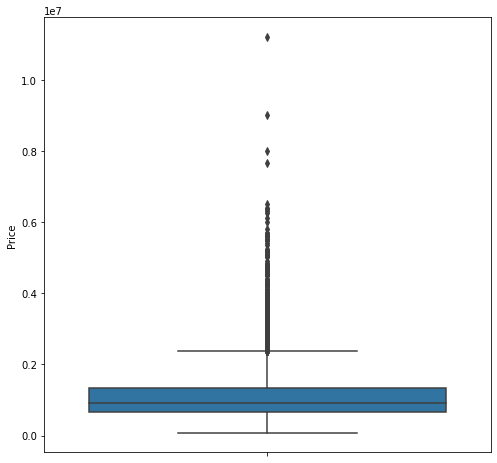

In [9]:
# boxplot
plt.figure(figsize = (8,8))
sns.boxplot(y = 'Price', data = df)

In [10]:
# deal with the outliers
# value < Q1 - 1,5*IQR OR value > Q3 + 1,5 * IQR
def finding_outliers(data, variable_name) :
    iqr = data[variable_name].quantile(0.75) - data[variable_name].quantile(0.25)
    lower =  data[variable_name].quantile(0.25) -1.5*iqr
    upper =  data[variable_name].quantile(0.75) + 1.5*iqr
    return data [(data[variable_name] < lower) | (data[variable_name] > upper)]

<AxesSubplot:ylabel='Bedroom2'>

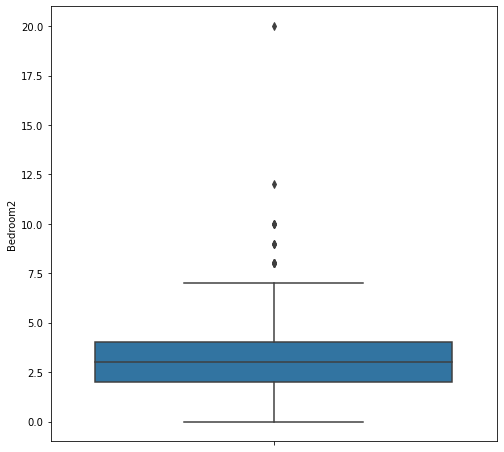

In [11]:
# boxplot
plt.figure(figsize = (8,8))
sns.boxplot(y = 'Bedroom2', data = df)

<AxesSubplot:ylabel='Bedroom2'>

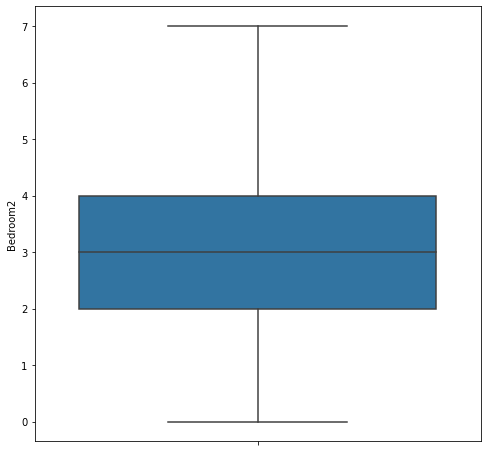

In [12]:
# bedroom outliers
finding_outliers(df, 'Bedroom2').sort_values('Bedroom2')

# for price
iqr_price = df['Bedroom2'].quantile(0.75) - df['Bedroom2'].quantile(0.25)
df['Bedroom2'].quantile(0.75) + 1.5 * iqr_price


df.loc[(finding_outliers(df, 'Bedroom2').index, 'Bedroom2')] = df['Bedroom2'].quantile(0.75) + 1.5 * iqr_price

# boxplot
plt.figure(figsize = (8,8))
sns.boxplot(y = 'Bedroom2', data = df)

<AxesSubplot:ylabel='Bathroom'>

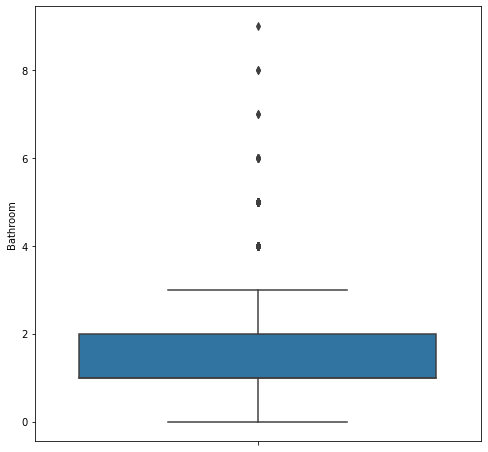

In [13]:
# boxplot
plt.figure(figsize = (8,8))
sns.boxplot(y = 'Bathroom', data = df)

<AxesSubplot:ylabel='Bathroom'>

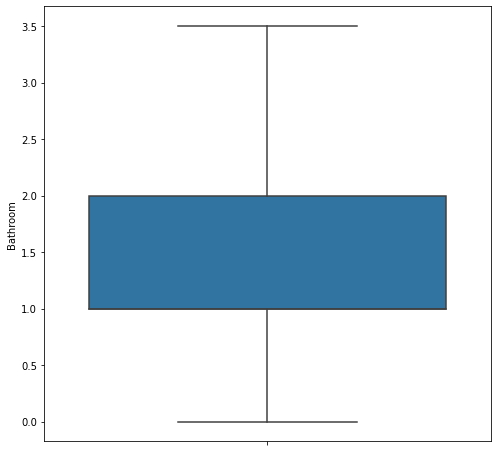

In [14]:
# bedroom outliers
finding_outliers(df, 'Bathroom').sort_values('Bathroom')

# for price
iqr_price = df['Bathroom'].quantile(0.75) - df['Bathroom'].quantile(0.25)
df['Bathroom'].quantile(0.75) + 1.5 * iqr_price


df.loc[(finding_outliers(df, 'Bathroom').index, 'Bathroom')] = df['Bathroom'].quantile(0.75) + 1.5 * iqr_price

# boxplot
plt.figure(figsize = (8,8))
sns.boxplot(y = 'Bathroom', data = df)

<AxesSubplot:xlabel='Bathroom', ylabel='Price'>

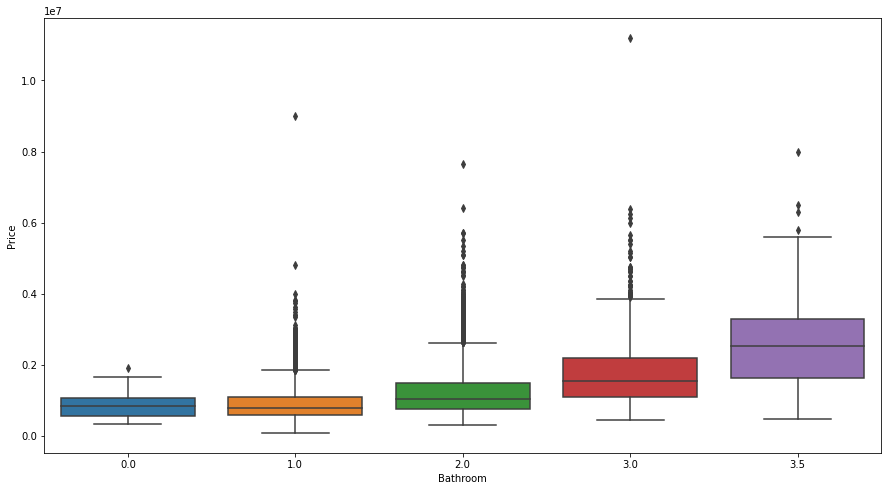

In [15]:
# Relationship between bathroom vs price
#plot  bathroom vs price
plt.figure(figsize = (15,8))
sns.boxplot(x = 'Bathroom', y = 'Price', data = df)

<AxesSubplot:xlabel='Bedroom2', ylabel='Price'>

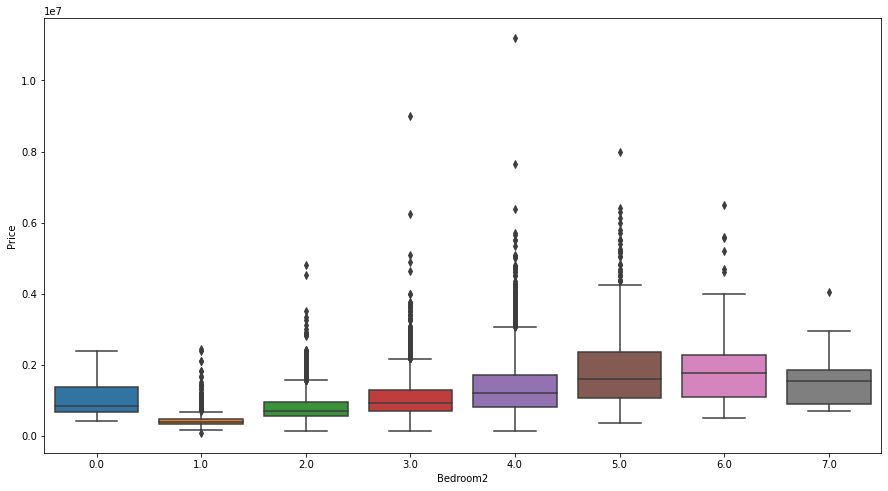

In [16]:
# Relationship between bedroom vs price
# plot  bedroom vs price
plt.figure(figsize = (15,8))
sns.boxplot(x = 'Bedroom2', y = 'Price', data = df)

<Figure size 1080x576 with 0 Axes>

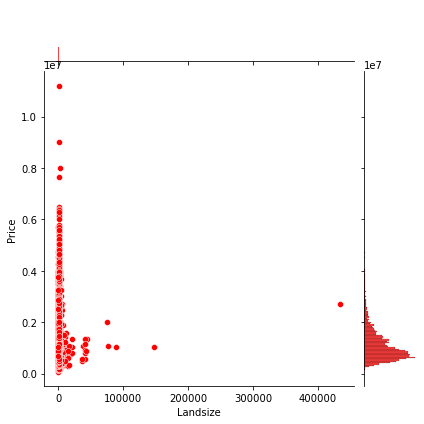

In [17]:
# Relationship between Landsize and price
# plot  bedroom vs price
plt.figure(figsize = (15,8))
sns.jointplot(x='Landsize', y='Price',data=df,color='red')

<AxesSubplot:xlabel='Bedroom2', ylabel='Price'>

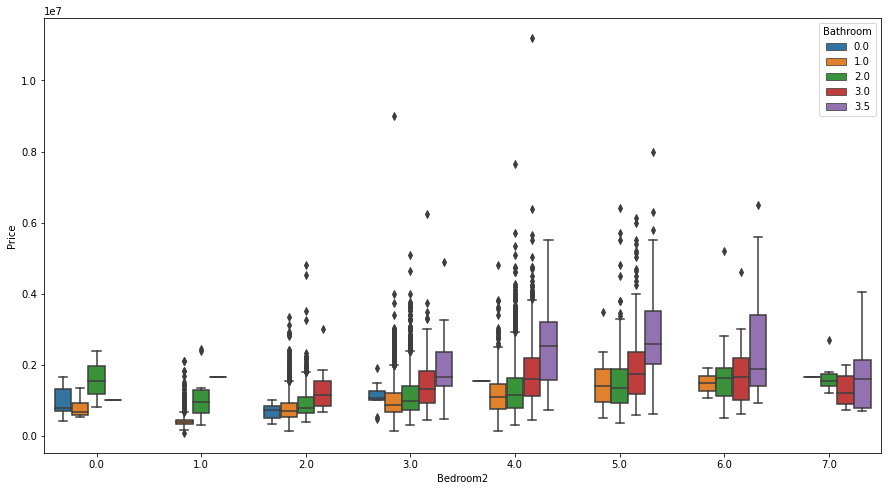

In [18]:
# relationship between price and Bedroom2 and Bathroom
plt.figure(figsize = (15,8))
sns.boxplot(x = 'Bedroom2', y = 'Price', hue = 'Bathroom', data = df)

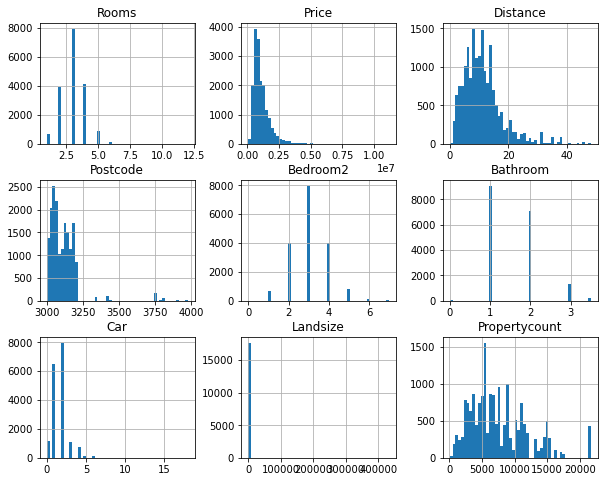

In [19]:
# plot each numerical attribute
df.hist(bins=50, figsize=(10, 8))
plt.show()

<AxesSubplot:xlabel='Bathroom', ylabel='count'>

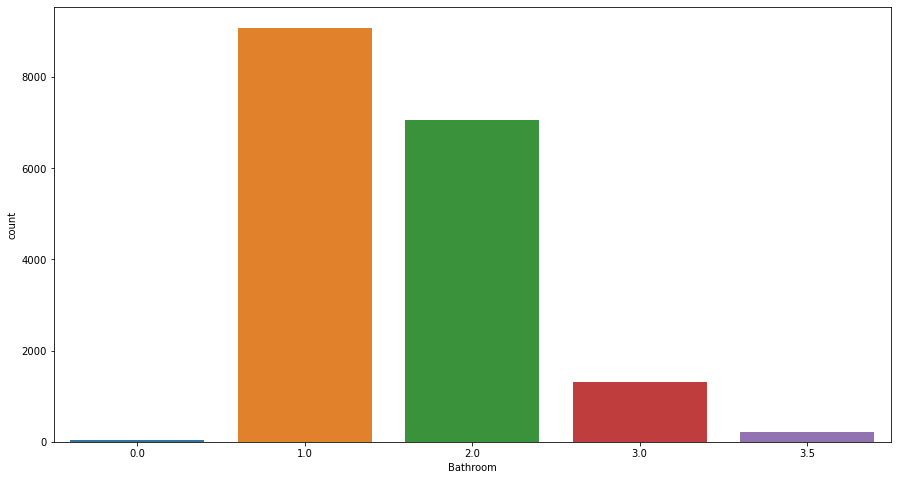

In [20]:
# plot bathroom
plt.figure(figsize = (15,8))
sns.countplot(x= 'Bathroom', data = df)

<AxesSubplot:xlabel='Bedroom2', ylabel='count'>

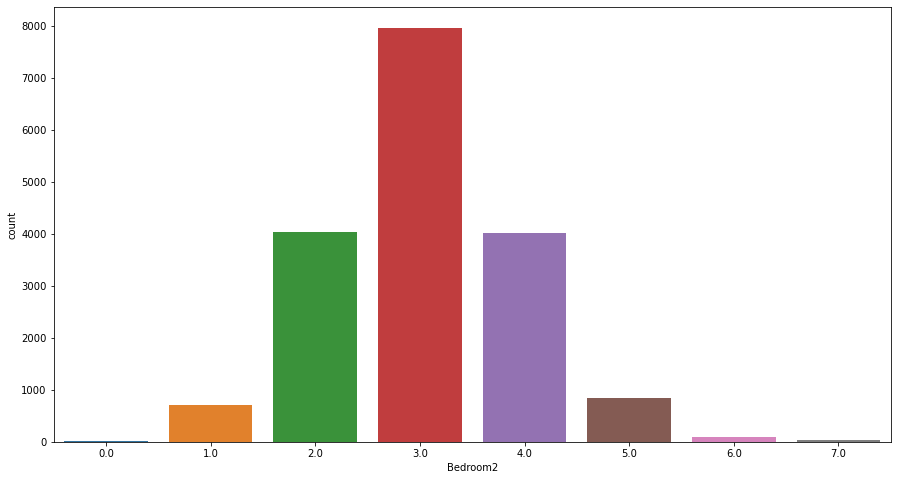

In [21]:
# plot Bedroom2
plt.figure(figsize = (15,8))
sns.countplot(x= 'Bedroom2', data = df)

<AxesSubplot:xlabel='Type', ylabel='count'>

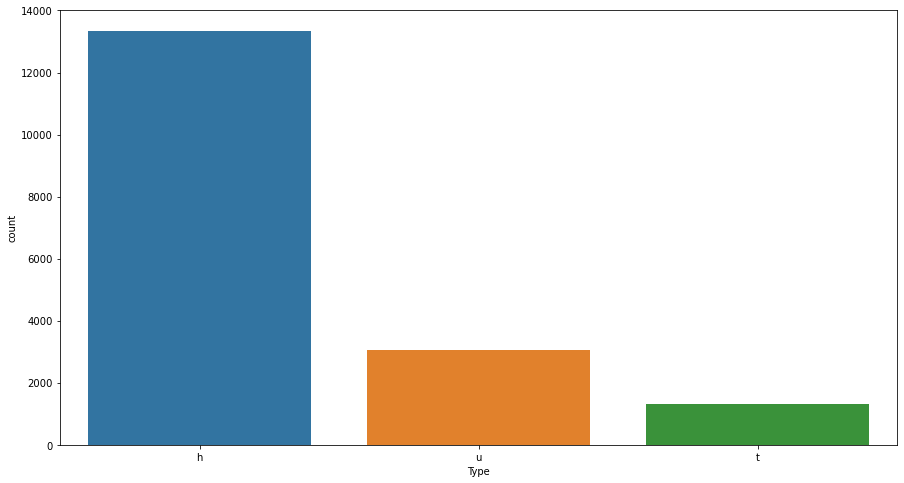

In [22]:
# plot type  of housing
plt.figure(figsize = (15,8))
sns.countplot(x= 'Type', data = df)

<AxesSubplot:xlabel='Car', ylabel='count'>

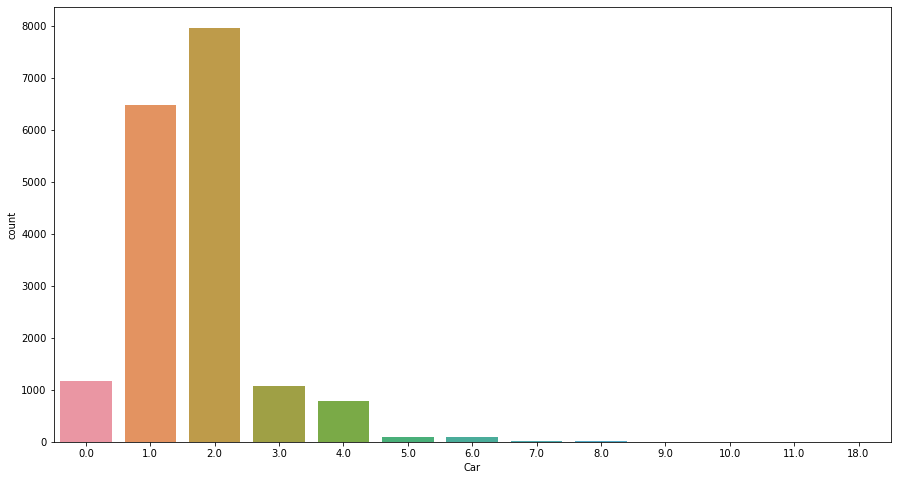

In [23]:
# plot car 
plt.figure(figsize = (15,8))
sns.countplot(x = 'Car', data = df)

[Text(0, 0, 'Northern Metropolitan'),
 Text(1, 0, 'Western Metropolitan'),
 Text(2, 0, 'Southern Metropolitan'),
 Text(3, 0, 'Eastern Metropolitan'),
 Text(4, 0, 'South-Eastern Metropolitan'),
 Text(5, 0, 'Eastern Victoria'),
 Text(6, 0, 'Northern Victoria'),
 Text(7, 0, 'Western Victoria')]

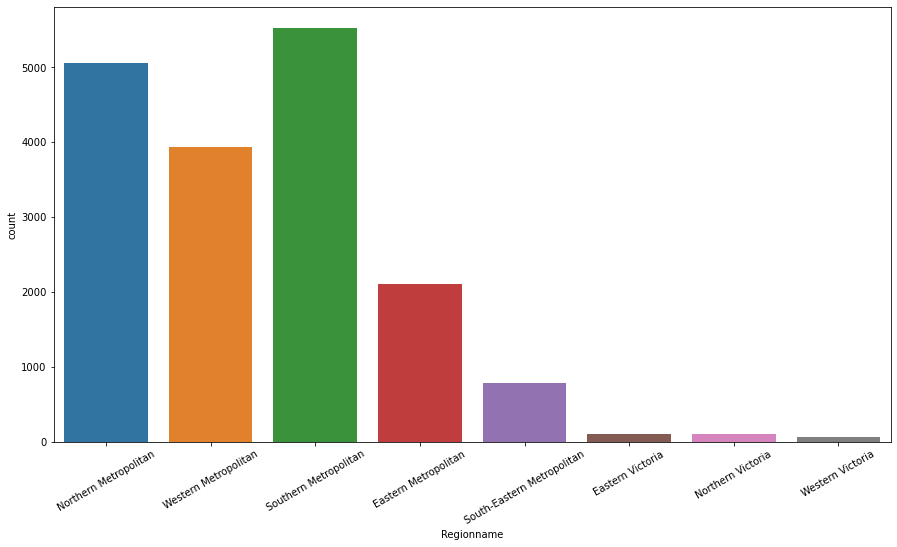

In [24]:
# plot regionname 
plt.figure(figsize = (15,8))
ax = sns.countplot(x = 'Regionname', data = df, )
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)

<AxesSubplot:xlabel='Propertycount', ylabel='Regionname'>

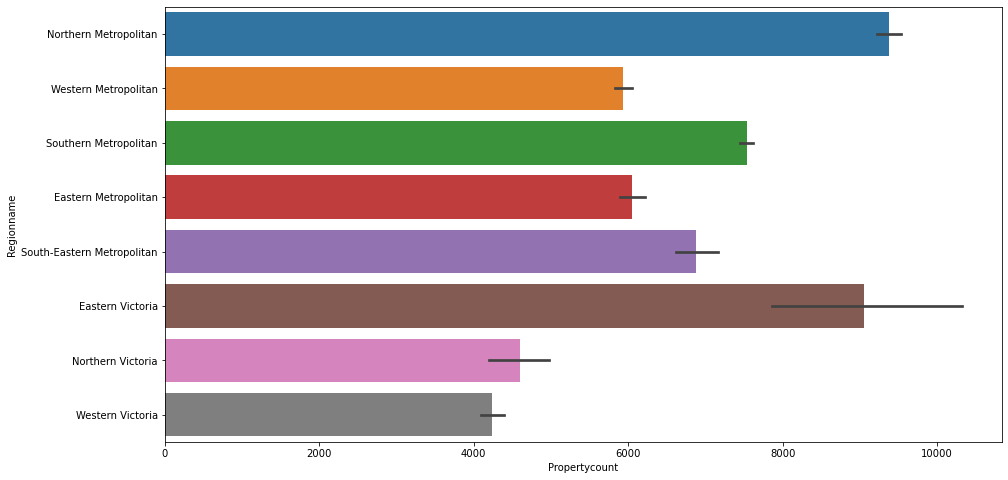

In [25]:
# plot propertycount
plt.figure(figsize = (15,8))
sns.barplot(x = 'Propertycount', y ='Regionname', data = df)

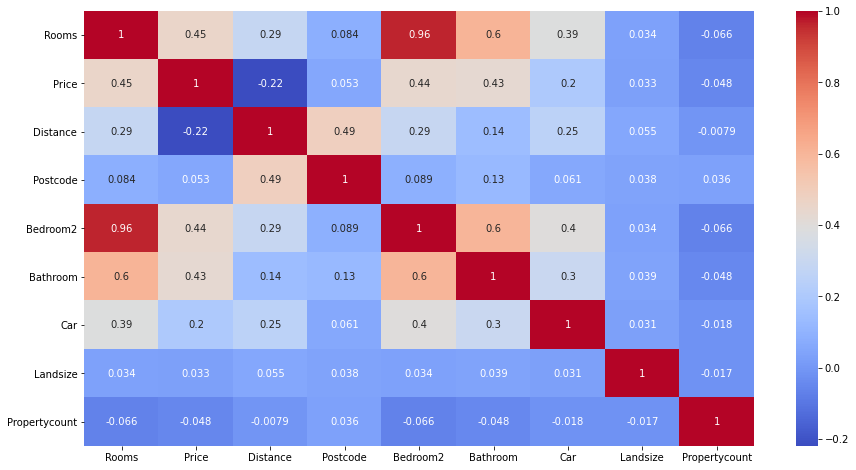

In [26]:
# heatmap
plt.figure(figsize=(15,8))
sns.heatmap(df.corr(),annot=True,cmap='coolwarm')
plt.savefig('heatmap.png')

## Data preparation

In [27]:
# identify the variable to convert to numerical variable
obj_df = df.select_dtypes(include=['object']).copy()
obj_df.head()

,Suburb,Address,Type,Date,CouncilArea,Regionname
1,Abbotsford,85 Turner St,h,3/12/2016,Yarra City Council,Northern Metropolitan
2,Abbotsford,25 Bloomburg St,h,4/02/2016,Yarra City Council,Northern Metropolitan
4,Abbotsford,5 Charles St,h,4/03/2017,Yarra City Council,Northern Metropolitan
5,Abbotsford,40 Federation La,h,4/03/2017,Yarra City Council,Northern Metropolitan
6,Abbotsford,55a Park St,h,4/06/2016,Yarra City Council,Northern Metropolitan


In [28]:
# Convert categorical data to numeric and separate target feature for training data

# defining our features and label
X = df.drop(['Price'], axis =1)
y = df['Price']



X= pd.get_dummies(X, columns=['Suburb',
                              'Address',
                               'Type',
                                'Date',
                                'CouncilArea',  
                                'Regionname'], drop_first=True)

In [30]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# validation data
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 42)

# Scala data
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Seth Help

In [39]:
len(df)

17701

In [34]:
X_test_scaled[0]

array([ 2.05603304, -0.49173648, -0.29945031, ..., -0.67508648,
       -0.53597829, -0.05832118])

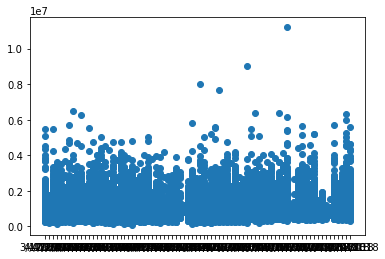

In [38]:
plt.scatter(df["Date"], df["Price"])

In [41]:
# ISO timestamp the Date column
df["Date"] = pd.to_datetime(df["Date"])
df.head()

,Suburb,Address,Rooms,Type,Price,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,CouncilArea,Regionname,Propertycount
1,Abbotsford,85 Turner St,2,h,1480000.0,2016-03-12,2.5,3067.0,2.0,1.0,1.0,202.0,Yarra City Council,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,2016-04-02,2.5,3067.0,2.0,1.0,0.0,156.0,Yarra City Council,Northern Metropolitan,4019.0
4,Abbotsford,5 Charles St,3,h,1465000.0,2017-04-03,2.5,3067.0,3.0,2.0,0.0,134.0,Yarra City Council,Northern Metropolitan,4019.0
5,Abbotsford,40 Federation La,3,h,850000.0,2017-04-03,2.5,3067.0,3.0,2.0,1.0,94.0,Yarra City Council,Northern Metropolitan,4019.0
6,Abbotsford,55a Park St,4,h,1600000.0,2016-04-06,2.5,3067.0,3.0,1.0,2.0,120.0,Yarra City Council,Northern Metropolitan,4019.0


In [44]:
x =np.array(df["Date"][:100]).reshape(-1,1)
modelR = LinearRegression().fit(x, df["Price"][:100])

In [48]:
m = modelR.coef_[0]
m

3.0468858582150863e-12

In [60]:
b = modelR.intercept_
b

-3414272.8605865026

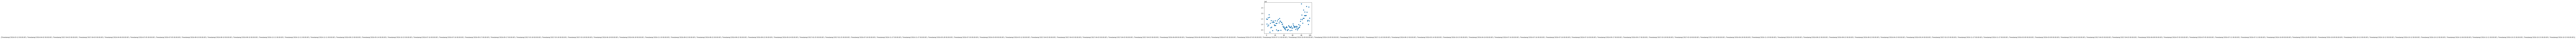

In [61]:
# Plot line of best fit
plt.scatter(np.arange(0, 100), df["Price"][:100])
plt.xlabel(list(df["Date"][:100]))
line_x = np.linspace(0, 100, 10)
line_y = m * line_x + b
# plt.plot(line_x, line_y)

## Data modeling

#### Linear Regression model

In [ ]:
# Fit the Linear Regression model with data
modelR = LinearRegression().fit(X_train_scaled, y_train)

In [ ]:
# Calculate training and testing score 
training_score = modelR.score(X_train_scaled, y_train)
testing_score = modelR.score(X_test_scaled, y_test)

In [ ]:
# Print the training and testing score
print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")

#### Random Forest model

In [ ]:
# Fit the Random Forest model with data
model_rf = RandomForestRegressor(n_estimators = 100, criterion = 'mse',
                              random_state = 42,
                             max_depth = 2).fit(X_train_scaled, y_train)

In [ ]:
# Calculate the training and testing score
training_score = model_rf.score(X_train, y_train)
testing_score = model_rf.score(X_test, y_test)

In [ ]:
# Print the training and testing score
print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")

#### Decision Tree model

In [ ]:
# Fit the Decision Tree model with data
model_tree = DecisionTreeRegressor(criterion = 'mse', 
                                  max_depth ='None', 
                                  min_samples_split= 2,
                                  min_sample_leaf=1, 
                                  max_feature = 1).fit(X_train_, y_train)

In [ ]:
# Calculate training and testing score 
training_score = model_tree.score(X_train, y_train)
testing_score = model_tree.score(X_train, y_test)

In [ ]:
# Print the training testing score
print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")

#### Randomized Search CV model

In [ ]:
# Fit the Randomized Search model with data
model_cv = randomizedSearchCV().fit(X_train_scaled, y_train)

In [ ]:
# Calculate training and testing score 
training_score = model_cv.score(X_train_scaled, y_train)
testing_score = model_cv.score(X_test_scaled, y_test)

In [ ]:
# Print the training testing score
print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")

#### Lasso model

In [ ]:
    #fit the lasso model with data
model_lasso = Lasso(alpha =1.0 , max_iter = 1000).fit(X_train_scaled, y_train)

In [ ]:
# Calculate training and testing score 
training_score = model_lasso.score(X_train_scaled, y_test)
testing_score = model_lasso.score(X_test_scaled, y_test)

In [ ]:
# Print the training testing score
print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")

#### Ridge model

In [ ]:
# Fit the Ridge model with data
model_Ridge = Ridge(alpha = 100).fit(X_train_scaled, y_train)

In [ ]:
# Calculate training and testing score 
training_score = model_Ridge.score(X_train_scaled, y_test)
testing_score = model_Ridge.score(X_test_scaled, y_test)

In [ ]:
# Print the training testing score
print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")

In [ ]:
# important variable
print(X_train_scaled.columns)
print(rf.feature_importances_)

In [ ]:
# see the importance by descending order
vars_imp = pd.Series(rf.feature_importances_, index = X_train_scaled.columns).sort_values(ascending = False)
vars_imp

In [ ]:
sns.barplot(x = vars_imp, y= vars_imp.index)
plt.show()

In [ ]:
# drop the less important variable 
vars_non_imp = ['x1', 'x2', .....]

X_train_scaled= X_train_scaled.drop(vars_non_imp, axis =1)
X_val = X_val.drop(vars_non_imp, axis =1)
X_test = X_test.drop(vars_non_imp, axis =1)

In [ ]:
# # random forest
#     #fit the Ridge model with data
# model = .fit(X_train_scaled, y_train)

#     # print the training testing score
# training_score = model.score(X_train, y_train)
# testing_score = model.score(X_test, y_test)

#     # print the training testing score
# print(f"Training Score: {training_score}")
# print(f"Testing Score: {testing_score}")


In [ ]:
# # Evaluation and choice of model
def model_evaluation(model, features, labels):
    pred = model.predict(features)
    score = accuracy_score(y_val, pred)
    print('Global Score :', round(score, 3))

In [ ]:
models = [modelR, model_tree, model_cv , model_lasso, model_Ridge, model_rf]
for model in models:
    print('model '+ str(model))
    model_evaluation(model, X_val, y_val)
    print(''*100)

In [ ]:
   # Predict the price
# y_pred = model_tree.predict(X_test)
# pd.DataFrame({"Prediction": y_pred, "Actual": y_test})